---

# Keras Sequential Neural Network to predict the probability of a phishing URL


---

In [1]:
#load packages and libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
import sklearn as sk
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import *
from keras.utils.np_utils import *
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json


print("Done Loading")


C:\Users\jorda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jorda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jorda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jorda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Done Loading


Using TensorFlow backend.


## load data

In [2]:
full_df = pd.read_csv("https://raw.githubusercontent.com/jwaldroop/phishing-url-project/main/dataset_full.csv")

full_df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [3]:
len(full_df[full_df.phishing == 1])

30647

In [4]:
len(full_df[full_df.phishing != 1])

58000

---

# unit testing to remove negative values (there cannot be a negative url length, etc.)

---

In [5]:
# Noticed a discrepancy in the data, some values are recorded as -1 even though it makes not practical sense, i.e. you can't have a negative quantity of a character
# This changes all -1 to 0
full_df.dtypes == 'int64'

def remove_negatives(full_df):
    full_df[full_df == -1] = 0
remove_negatives(full_df)

In [6]:
# unit test 
is_it_working = []
def data_cleaning_unit_test(column):
    did_it_work =  {'Yes':0 , 'No':0}
    for i in column:
        if i >= 0:
            did_it_work['Yes'] += 1
        elif i <0:
            did_it_work['No'] += 1
    if did_it_work['No'] > 0:
        print(column.name,'=', 'Not working')
    else:
        print(column.name,'=', 'It worked!')

In [7]:
for col in full_df.columns.tolist():
    data_cleaning_unit_test(full_df[col])

qty_dot_url = It worked!
qty_hyphen_url = It worked!
qty_underline_url = It worked!
qty_slash_url = It worked!
qty_questionmark_url = It worked!
qty_equal_url = It worked!
qty_at_url = It worked!
qty_and_url = It worked!
qty_exclamation_url = It worked!
qty_space_url = It worked!
qty_tilde_url = It worked!
qty_comma_url = It worked!
qty_plus_url = It worked!
qty_asterisk_url = It worked!
qty_hashtag_url = It worked!
qty_dollar_url = It worked!
qty_percent_url = It worked!
qty_tld_url = It worked!
length_url = It worked!
qty_dot_domain = It worked!
qty_hyphen_domain = It worked!
qty_underline_domain = It worked!
qty_slash_domain = It worked!
qty_questionmark_domain = It worked!
qty_equal_domain = It worked!
qty_at_domain = It worked!
qty_and_domain = It worked!
qty_exclamation_domain = It worked!
qty_space_domain = It worked!
qty_tilde_domain = It worked!
qty_comma_domain = It worked!
qty_plus_domain = It worked!
qty_asterisk_domain = It worked!
qty_hashtag_domain = It worked!
qty_dolla

In [8]:
full_df.describe()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,...,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000
mean,2.191343,0.328810,0.113879,1.281781,0.009329,0.205861,0.022133,0.140885,0.002944,0.001015,...,1.186797,2.772412,1.742428,6159.927758,0.506447,0.422293,0.002425,0.003012,0.005482,0.345720
std,1.235636,1.119286,0.657767,1.893929,0.112568,0.954272,0.279652,0.924864,0.087341,0.072653,...,0.796456,1.322999,1.706705,11465.556814,0.499961,0.689952,0.049188,0.054799,0.073841,0.475605
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2029.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10798.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,24.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000


---

# NN on entire dataset

### (this can take a while to run depending on your computer resources)

---

In [9]:
y = full_df.iloc[:,-1]

X = full_df.iloc[:,0:111]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
5676,1,0,0,1,0,0,0,0,0,0,...,209,1,6,2,3011,1,0,0,0,0
39002,3,0,0,0,0,0,0,0,0,0,...,2625,4,4,2,247,1,1,0,0,0
1732,2,0,0,0,0,0,0,0,0,0,...,350,1,2,1,14399,0,0,0,0,0
39668,2,0,0,0,0,0,0,0,0,0,...,97,1,2,4,7199,0,1,0,0,0
82035,2,0,0,0,0,0,0,0,0,0,...,269,1,4,4,21598,0,0,0,0,0


In [10]:
tf.keras.backend.clear_session() #clear tensorflow backend to help with memory leakage

nn_mod_1 = keras.Sequential([
                          layers.InputLayer(input_shape=[111]),                   # first layer - input - number of columns in X
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

nn_mod_1.compile(
    optimizer='adam', #best optimizer for noise, easy computation
    loss='binary_crossentropy', #crossentropy between preds and val_y; preds are between 0 & 1 so we use binary
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), #binary accuracy between preds and val_y with 0.5 threshold
             tf.keras.metrics.AUC(), # measuring AUC (obviously) through internal measures of TP, TN, FP, FN
             ]
)

# early stopping callback will monitor the validation data's binary accuracy for it's maximum value
# & 25 epochs after reaching the maximum value, the model will stop running and restore the best layer weights measured.
# I don't actually want this to run for anywhere near 500 epochs but this gives it the flexibility to learn as long as needed

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)

# this will output a table of the layers, each layer output shape, and the parameters measured by the model
nn_mod_1.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
__________________________________________

In [11]:
history1 = nn_mod_1.fit(train_X, train_y, validation_split=0.30, shuffle=True, batch_size= 1500, epochs=250, callbacks = [earlystopping], workers=8)

# this fit method does not use the original validation split (25%) during model fitting to allow for more accurate evaluation and preditions later on
# the 75% training split (train_X, train_y) is split 70/30 during model fitting and each epoch the 70/30 split is, well, shuffled
# and there are 8 workers to *hopefully* help it run faster, in addition to the early stopping callback being applied

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 41us/sample - loss: 0.7155 - binary_accuracy: 0.5616 - auc: 0.5150 - val_loss: 0.6503 - val_binary_accuracy: 0.6592 - val_auc: 0.5044
Epoch 2/250
46539/46539 [==============================] - 1s 16us/sample - loss: 0.6445 - binary_accuracy: 0.6413 - auc: 0.5935 - val_loss: 0.6282 - val_binary_accuracy: 0.6592 - val_auc: 0.7549
Epoch 3/250
46539/46539 [==============================] - ETA: 0s - loss: 0.6060 - binary_accuracy: 0.6669 - auc: 0.6778- ETA: 0s - loss: 0.6189 - binary_accuracy: 0.6559 - auc - 1s 16us/sample - loss: 0.6063 - binary_accuracy: 0.6663 - auc: 0.6774 - val_loss: 0.5909 - val_binary_accuracy: 0.6591 - val_auc: 0.7772
Epoch 4/250
46539/46539 [==============================] - 1s 15us/sample - loss: 0.5754 - binary_accuracy: 0.6868 - auc: 0.7278 - val_loss: 0.5490 - val_binary_accuracy: 0.6592 - val_auc: 0.7923
Epoch 5/250
46539/46539 [====================

In [12]:
#turn model fit metric measures into a pandas dataframe

history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.301841,0.866200,0.923018,0.324455,0.852530,0.931889
std,0.110745,0.071151,0.077579,0.146510,0.082130,0.071409
min,0.209422,0.561636,0.515034,0.190111,0.606237,0.504444
25%,0.230321,0.870845,0.930793,0.219109,0.814386,0.929184
50%,0.246963,0.900986,0.957750,0.261933,0.891281,0.964439
75%,0.316497,0.907690,0.963429,0.377817,0.915246,0.971990
max,0.715541,0.918262,0.969667,0.875137,0.929359,0.977234


## evaluating the model and getting the overall model metrics following model fitting

In [13]:
#tf.keras function to evaluate the model & record best metrics

train_acc = nn_mod_1.evaluate(train_X, train_y)  # evaluation w/ best measures of training data -- aka model fit
test_acc = nn_mod_1.evaluate(val_X, val_y)       # evaluation w/ best measures of validation/testing data -- the model hasn't seen this data before so super important!

22162/22162 [==============================] - 4s 159us/sample - loss: 0.2026 - binary_accuracy: 0.9262 - auc: 0.9742


In [14]:
# display validation/testing evaluation metrics in a different way

dict(zip(nn_mod_1.metrics_names, test_acc))

{'loss': 0.20256852179795284, 'binary_accuracy': 0.92617995, 'auc': 0.97417265}

### graphs of the training vs. validation metrics across model fitting

Minimum validation loss (binary_crossentropy): 0.19011065838426117


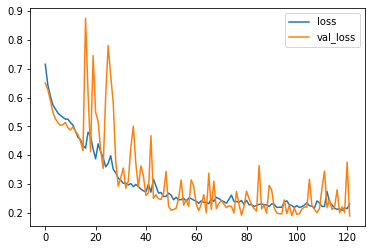

In [15]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9772337079048157


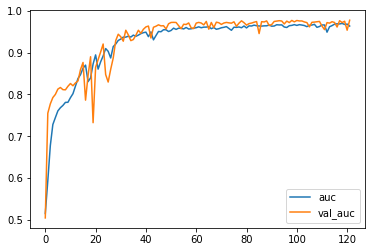

In [16]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9293592572212219


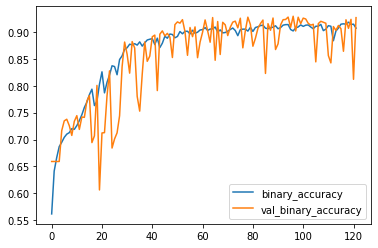

In [17]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [18]:
history_df1.binary_accuracy.max() - history_df1.val_binary_accuracy.max()

-0.011097133159637451

## making predictions

In [19]:
preds1 = nn_mod_1.predict(val_X) # this is tf.keras function & could be called on the entire dataset but it's not fair to ask the model to predict on data already seen
preds1

array([[0.905722  ],
       [0.00466016],
       [0.40403613],
       ...,
       [0.08140433],
       [0.00584551],
       [0.8968639 ]], dtype=float32)

In [20]:
preds = (nn_mod_1.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13662   857]
 [  779  6864]]


In [21]:
# turn predictions into pandas dataframe

preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.905722
1,0.004660
2,0.404036
3,0.008905
4,0.340527


In [22]:
# attach predictions to original validation data (val_X & val_y) for easier locating, plotting, etc.

preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,...,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
0,0.905722,1,62575,4,0,0,5,0,0,0,...,542,2,2,1,14350,0,0,0,0,0
1,0.004660,0,38126,2,0,0,0,0,0,0,...,243,1,2,1,14388,1,0,0,0,0
2,0.404036,0,1617,2,1,0,1,0,0,0,...,216,2,2,5,275,1,2,0,0,0
3,0.008905,0,8228,2,0,0,0,0,0,0,...,1065,1,2,1,14389,1,1,0,0,0
4,0.340527,1,55594,2,0,1,2,0,0,0,...,0,0,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22157,0.003965,0,65294,3,0,0,0,0,0,0,...,99,1,2,1,3589,1,1,0,0,0
22158,0.004692,0,10038,2,0,0,0,0,0,0,...,2487,2,2,5,299,1,1,0,0,0
22159,0.081404,0,43642,2,0,0,0,0,0,0,...,0,1,2,2,292,0,0,0,0,0
22160,0.005846,0,73632,2,1,0,0,0,0,0,...,361,1,2,4,21597,0,1,0,0,0


# neural network on URL attributes (table 1)

### (20 features)

In [23]:
y = full_df['phishing']

features_table1 = ['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url',
                   'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url',
                   'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url', 'qty_tld_url',
                   'length_url', 'email_in_url'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,email_in_url
5676,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,0
39002,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,0
1732,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,0
39668,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0
82035,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,28,0


### neural net - build/fit/predict

In [24]:
tf.keras.backend.clear_session()

#neural net

table1_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[20]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])


table1_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table1_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [25]:
history = table1_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 46us/sample - loss: 0.6096 - binary_accuracy: 0.6797 - auc: 0.7117 - val_loss: 0.6177 - val_binary_accuracy: 0.6881 - val_auc: 0.8195
Epoch 2/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.4260 - binary_accuracy: 0.8306 - auc: 0.8779 - val_loss: 0.4546 - val_binary_accuracy: 0.8282 - val_auc: 0.9178
Epoch 3/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.3658 - binary_accuracy: 0.8580 - auc: 0.9101 - val_loss: 0.3787 - val_binary_accuracy: 0.8465 - val_auc: 0.9367
Epoch 4/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.3385 - binary_accuracy: 0.8660 - auc: 0.9226 - val_loss: 0.3488 - val_binary_accuracy: 0.8524 - val_auc: 0.9451
Epoch 5/250
46539/46539 [==============================] - 1s 21us/sample - loss: 0.3166 - binary_accuracy: 0.8710 - auc: 0.9314 - val_loss: 0.3397 - val_binary_accur

In [26]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.266291,0.884688,0.946359,0.260490,0.891087,0.957909
std,0.052281,0.027205,0.031523,0.058867,0.028688,0.018551
min,0.240858,0.679688,0.711740,0.230283,0.688108,0.819509
25%,0.245273,0.886482,0.949228,0.236627,0.893663,0.958385
50%,0.251618,0.890243,0.953639,0.241028,0.899228,0.961980
75%,0.263621,0.892649,0.955723,0.251131,0.900958,0.963633
max,0.609557,0.895679,0.957543,0.617736,0.903540,0.965317


In [27]:
train_acc = table1_nn.evaluate(train_X, train_y)
test_acc = table1_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 4s 173us/sample - loss: 0.2447 - binary_accuracy: 0.9014 - auc: 0.9604


In [28]:
dict(zip(table1_nn.metrics_names, test_acc))

{'loss': 0.24467309599382742, 'binary_accuracy': 0.9013627, 'auc': 0.96040213}

Minimum validation loss (binary_crossentropy): 0.2302826552011299


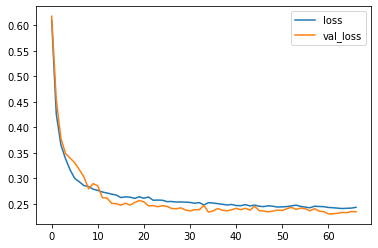

In [29]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.9653172492980957


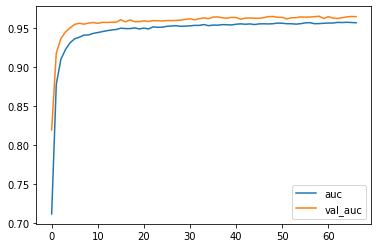

In [30]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.9035395383834839


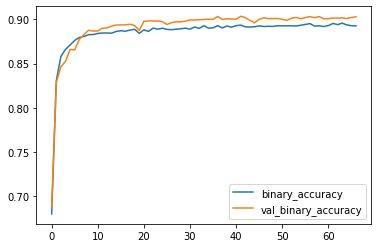

In [31]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [32]:
preds1 = table1_nn.predict(val_X)
preds1

array([[0.80981195],
       [0.00788555],
       [0.78338236],
       ...,
       [0.00754762],
       [0.00921346],
       [0.59152067]], dtype=float32)

In [33]:
preds = (table1_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13399  1120]
 [ 1066  6577]]


# neural network on dataset attributes based on domain URL (table 2)

### (21 features)

In [34]:
y = full_df['phishing']

features_table1 = ['qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain', 'qty_and_domain',
                   'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain',
                   'qty_percent_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip', 'server_client_domain'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,...,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain
5676,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,10,0,0
39002,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,13,0,0
1732,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,16,0,0
39668,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,26,0,0
82035,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,28,0,0


In [35]:
X.shape

(88647, 21)

In [36]:
tf.keras.backend.clear_session()

#neural net

table2_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[21]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

table2_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table2_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [37]:
history = table2_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 47us/sample - loss: 0.7134 - binary_accuracy: 0.5694 - auc: 0.5277 - val_loss: 0.6497 - val_binary_accuracy: 0.6597 - val_auc: 0.4836
Epoch 2/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.6447 - binary_accuracy: 0.6461 - auc: 0.5889 - val_loss: 0.6428 - val_binary_accuracy: 0.6592 - val_auc: 0.4509
Epoch 3/250
46539/46539 [==============================] - 1s 20us/sample - loss: 0.6182 - binary_accuracy: 0.6711 - auc: 0.6500 - val_loss: 0.6498 - val_binary_accuracy: 0.6592 - val_auc: 0.5080
Epoch 4/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.6025 - binary_accuracy: 0.6854 - auc: 0.6795 - val_loss: 0.6561 - val_binary_accuracy: 0.6592 - val_auc: 0.6189
Epoch 5/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5923 - binary_accuracy: 0.6926 - auc: 0.6971 - val_loss: 0.6392 - val_binary_accur

In [38]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,0.560926,0.722413,0.731463,0.559216,0.727848,0.739562
std,0.025040,0.024077,0.034565,0.028495,0.024841,0.058360
min,0.544659,0.569415,0.527735,0.537090,0.659230,0.450931
25%,0.548057,0.722244,0.731839,0.543366,0.730397,0.747190
50%,0.553615,0.728765,0.739692,0.551170,0.734583,0.754149
75%,0.561600,0.733503,0.747580,0.559312,0.742906,0.761075
max,0.713418,0.737962,0.753159,0.656098,0.751379,0.768156


In [39]:
train_acc = table2_nn.evaluate(train_X, train_y)
test_acc = table2_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 3s 145us/sample - loss: 0.5535 - binary_accuracy: 0.7506 - auc: 0.7567


In [40]:
dict(zip(table2_nn.metrics_names, test_acc))

{'loss': 0.5534592719620697, 'binary_accuracy': 0.75060916, 'auc': 0.7566705}

Minimum validation loss (binary_crossentropy): 0.5370896356784507


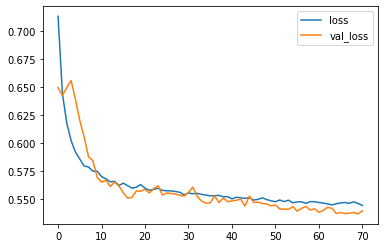

In [41]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.7681562304496765


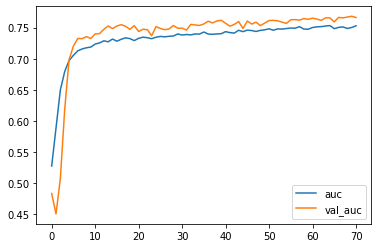

In [42]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.7513787150382996


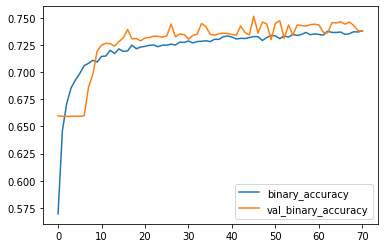

In [43]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [44]:
preds1 = table2_nn.predict(val_X)
preds1

array([[0.13336003],
       [0.13842297],
       [0.13452363],
       ...,
       [0.13882932],
       [0.32686552],
       [0.13643834]], dtype=float32)

In [45]:
preds = (table2_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[12262  2257]
 [ 3270  4373]]


# neural network on dataset attributes based on URL directory (table 3)

### (18 features)

In [46]:
y = full_df['phishing']

features_table1 = ['qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory',
                   'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory',
                   'qty_percent_directory', 'directory_length'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,qty_percent_directory,directory_length
5676,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
X.shape

(88647, 18)

In [48]:
tf.keras.backend.clear_session()

#neural net

table3_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[18]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

table3_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table3_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [49]:
history = table3_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 42us/sample - loss: 0.5423 - binary_accuracy: 0.7464 - auc: 0.8115 - val_loss: 0.5554 - val_binary_accuracy: 0.7073 - val_auc: 0.9420
Epoch 2/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.3934 - binary_accuracy: 0.8537 - auc: 0.9053 - val_loss: 0.4675 - val_binary_accuracy: 0.7838 - val_auc: 0.9031
Epoch 3/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.3517 - binary_accuracy: 0.8663 - auc: 0.9185 - val_loss: 0.4182 - val_binary_accuracy: 0.7997 - val_auc: 0.9429
Epoch 4/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.3291 - binary_accuracy: 0.8716 - auc: 0.9254 - val_loss: 0.3894 - val_binary_accuracy: 0.8188 - val_auc: 0.9429
Epoch 5/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.3195 - binary_accuracy: 0.8719 - auc: 0.9266 - val_loss: 0.3917 - val_binary_accur

In [50]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.270226,0.887161,0.944917,0.267590,0.889735,0.951829
std,0.036595,0.016575,0.016115,0.049146,0.027389,0.005898
min,0.251798,0.746385,0.811505,0.245047,0.707310,0.903147
25%,0.255576,0.887320,0.945762,0.249477,0.895518,0.952552
50%,0.259411,0.891553,0.949169,0.252165,0.896621,0.953209
75%,0.270801,0.892993,0.950131,0.259432,0.896922,0.953713
max,0.542266,0.894798,0.951196,0.555432,0.897473,0.954623


In [51]:
train_acc = table3_nn.evaluate(train_X, train_y)
test_acc = table3_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 3s 154us/sample - loss: 0.2518 - binary_accuracy: 0.8982 - auc: 0.9536


In [52]:
dict(zip(table3_nn.metrics_names, test_acc))

{'loss': 0.2517897097650885, 'binary_accuracy': 0.89824927, 'auc': 0.9536314}

Minimum validation loss (binary_crossentropy): 0.24504735126492252


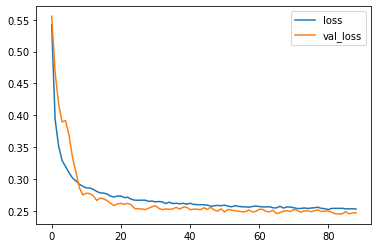

In [53]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.9546228647232056


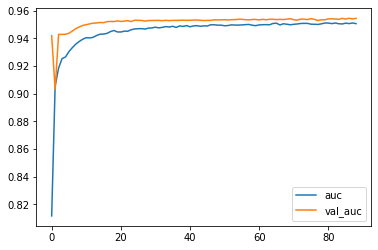

In [54]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.897473156452179


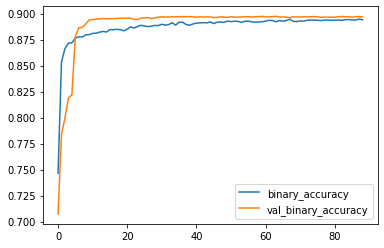

In [55]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [56]:
preds1 = table3_nn.predict(val_X)
preds1

array([[0.9094484 ],
       [0.01058102],
       [0.699705  ],
       ...,
       [0.01058102],
       [0.01058107],
       [0.70757234]], dtype=float32)

In [57]:
preds = (table3_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13277  1242]
 [ 1013  6630]]


# neural network on dataset attributes based on URL file name (table 4)

### (18 features)

In [58]:
y = full_df['phishing']

features_table1 = ['qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file',
                   'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
                   'qty_percent_file', 'file_length'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_file,qty_hyphen_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length
5676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
X.shape

(88647, 18)

In [60]:
tf.keras.backend.clear_session()

#neural net

table4_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[18]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

table4_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table4_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [61]:
history = table4_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 43us/sample - loss: 0.6597 - binary_accuracy: 0.6469 - auc: 0.6319 - val_loss: 0.6384 - val_binary_accuracy: 0.6598 - val_auc: 0.7169
Epoch 2/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.5515 - binary_accuracy: 0.7668 - auc: 0.7373 - val_loss: 0.6481 - val_binary_accuracy: 0.6601 - val_auc: 0.4284
Epoch 3/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.5269 - binary_accuracy: 0.7890 - auc: 0.7453 - val_loss: 0.6240 - val_binary_accuracy: 0.6597 - val_auc: 0.7472
Epoch 4/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.5163 - binary_accuracy: 0.7960 - auc: 0.7514 - val_loss: 0.5582 - val_binary_accuracy: 0.6631 - val_auc: 0.7570
Epoch 5/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.5088 - binary_accuracy: 0.7992 - auc: 0.7549 - val_loss: 0.5211 - val_binary_accur

In [62]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.500304,0.800455,0.750850,0.500926,0.794796,0.750969
std,0.031379,0.028293,0.021419,0.045434,0.049750,0.057599
min,0.483777,0.646920,0.631947,0.479864,0.659731,0.428408
25%,0.486511,0.804481,0.753119,0.482250,0.812694,0.761785
50%,0.491214,0.807849,0.755115,0.483237,0.812945,0.762412
75%,0.500532,0.808859,0.756364,0.487557,0.813283,0.763137
max,0.659735,0.809858,0.759307,0.648140,0.813747,0.764928


In [63]:
train_acc = table4_nn.evaluate(train_X, train_y)
test_acc = table4_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 4s 167us/sample - loss: 0.4886 - binary_accuracy: 0.8107 - auc: 0.7581


In [64]:
dict(zip(table4_nn.metrics_names, test_acc))

{'loss': 0.48859232150145293, 'binary_accuracy': 0.81071204, 'auc': 0.7580929}

Minimum validation loss (binary_crossentropy): 0.479864005529449


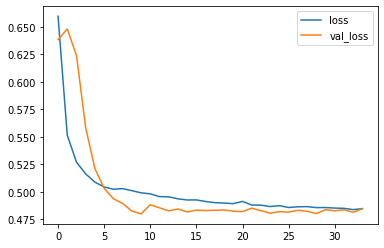

In [65]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.7649281024932861


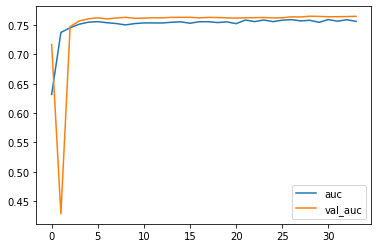

In [66]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.8137471079826355


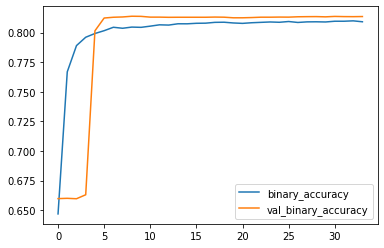

In [67]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [68]:
preds1 = table4_nn.predict(val_X)
preds1

array([[0.75737584],
       [0.18060318],
       [0.7292878 ],
       ...,
       [0.18060318],
       [0.18060318],
       [0.7577492 ]], dtype=float32)

In [69]:
preds = (table4_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13698   821]
 [ 3374  4269]]


# neural network on dataset attributes based on URL parameters (table 5)

### (20 features)

In [70]:
y = full_df['phishing']

features_table1 = ['qty_dot_params', 'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params', 'qty_questionmark_params', 'qty_equal_params', 'qty_at_params', 'qty_and_params',
                   'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params',
                   'qty_percent_params', 'params_length', 'tld_present_params', 'qty_params'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params
5676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
X.shape

(88647, 20)

In [72]:
tf.keras.backend.clear_session()

#neural net

table5_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[20]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

table5_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table5_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [73]:
history = table5_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 45us/sample - loss: 0.6803 - binary_accuracy: 0.6057 - auc: 0.5509 - val_loss: 0.6259 - val_binary_accuracy: 0.6901 - val_auc: 0.5387
Epoch 2/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.6195 - binary_accuracy: 0.6879 - auc: 0.5798 - val_loss: 0.6169 - val_binary_accuracy: 0.6869 - val_auc: 0.5503
Epoch 3/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.6067 - binary_accuracy: 0.7023 - auc: 0.5904 - val_loss: 0.6162 - val_binary_accuracy: 0.6852 - val_auc: 0.5434
Epoch 4/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5992 - binary_accuracy: 0.7069 - auc: 0.5960 - val_loss: 0.6176 - val_binary_accuracy: 0.6829 - val_auc: 0.5797
Epoch 5/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5978 - binary_accuracy: 0.7102 - auc: 0.5934 - val_loss: 0.6177 - val_binary_accur

In [74]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,0.581545,0.717358,0.602621,0.577767,0.721830,0.599420
std,0.013096,0.013028,0.006937,0.012729,0.011336,0.015202
min,0.574119,0.605664,0.550931,0.569801,0.682894,0.512338
25%,0.575718,0.718397,0.601784,0.571717,0.724281,0.602962
50%,0.578090,0.720063,0.603327,0.573200,0.726161,0.603805
75%,0.582021,0.720938,0.605578,0.575568,0.726261,0.604112
max,0.680286,0.721588,0.609787,0.625905,0.726662,0.604729


In [75]:
train_acc = table5_nn.evaluate(train_X, train_y)
test_acc = table5_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 3s 154us/sample - loss: 0.5766 - binary_accuracy: 0.7255 - auc: 0.6068


In [76]:
dict(zip(table5_nn.metrics_names, test_acc))

{'loss': 0.5765615259522018, 'binary_accuracy': 0.725476, 'auc': 0.6067649}

Minimum validation loss (binary_crossentropy): 0.5698011233456859


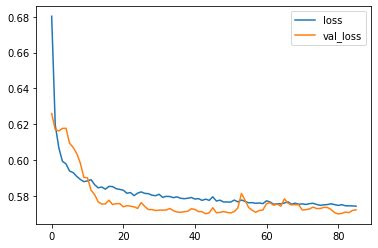

In [77]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.6047291159629822


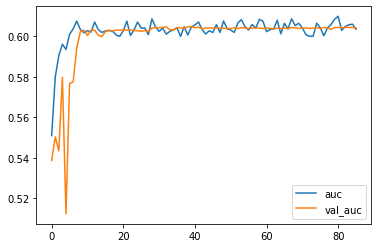

In [78]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.7266619801521301


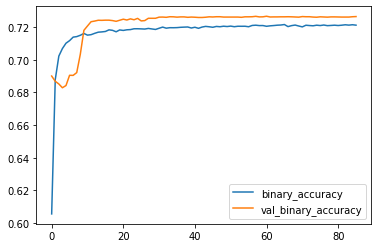

In [79]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [80]:
preds1 = table5_nn.predict(val_X)
preds1

array([[0.27296707],
       [0.27296707],
       [0.27296707],
       ...,
       [0.27296707],
       [0.2729671 ],
       [0.2729671 ]], dtype=float32)

In [81]:
preds = (table5_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[14392   127]
 [ 5957  1686]]


# neural network on dataset attributes based on URL resolving data and external metrics (table 6)

### (14 features)

In [82]:
y = full_df['phishing']

features_table1 = ['time_response', 'domain_spf', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname', 'tls_ssl_certificate',
                   'qty_redirects', 'url_google_index', 'domain_google_index', 'url_shortened'] 

X = full_df[features_table1]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=808)

train_X.head()

,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
5676,8.696835,0,262254,155,209,1,6,2,3011,1,0,0,0,0
39002,0.244978,0,2818,0,2625,4,4,2,247,1,1,0,0,0
1732,0.430590,0,15169,5858,350,1,2,1,14399,0,0,0,0,0
39668,0.617731,0,14061,4285,97,1,2,4,7199,0,1,0,0,0
82035,0.149499,0,29671,6669,269,1,4,4,21598,0,0,0,0,0


In [83]:
X.shape

(88647, 14)

In [84]:
tf.keras.backend.clear_session()

#neural net

table6_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[14]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

table6_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


table6_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                960       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [85]:
history = table6_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 43us/sample - loss: 0.7101 - binary_accuracy: 0.5570 - auc: 0.5367 - val_loss: 0.6477 - val_binary_accuracy: 0.6592 - val_auc: 0.4615
Epoch 2/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.6285 - binary_accuracy: 0.6475 - auc: 0.6367 - val_loss: 0.6249 - val_binary_accuracy: 0.6592 - val_auc: 0.7071
Epoch 3/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.5932 - binary_accuracy: 0.6666 - auc: 0.6971 - val_loss: 0.5855 - val_binary_accuracy: 0.6592 - val_auc: 0.7465
Epoch 4/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.5767 - binary_accuracy: 0.6747 - auc: 0.7204 - val_loss: 0.5600 - val_binary_accuracy: 0.6591 - val_auc: 0.7451
Epoch 5/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5613 - binary_accuracy: 0.6874 - auc: 0.7391 - val_loss: 0.5372 - val_binary_accur

In [86]:
history_df = pd.DataFrame(history.history)

history_df.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.502030,0.740938,0.804001,0.487560,0.754412,0.822608
std,0.029345,0.024550,0.035518,0.024697,0.020748,0.037024
min,0.482462,0.557017,0.536741,0.470168,0.659079,0.461544
25%,0.486657,0.738784,0.801561,0.476036,0.753835,0.824584
50%,0.492224,0.748834,0.815441,0.480723,0.760754,0.830493
75%,0.505657,0.752998,0.821011,0.488717,0.764138,0.834696
max,0.710080,0.756355,0.824724,0.647737,0.772436,0.837887


In [87]:
train_acc = table6_nn.evaluate(train_X, train_y)
test_acc = table6_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 4s 162us/sample - loss: 0.4753 - binary_accuracy: 0.7691 - auc: 0.8365


In [88]:
dict(zip(table6_nn.metrics_names, test_acc))

{'loss': 0.4752918251552002, 'binary_accuracy': 0.7690642, 'auc': 0.8365437}

Minimum validation loss (binary_crossentropy): 0.4701679882895178


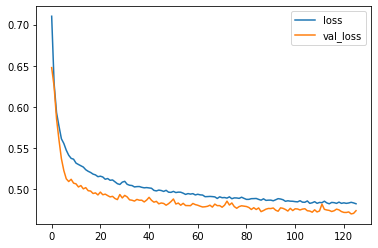

In [89]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df['val_loss'].min()))

Maximum AUC: 0.8378874063491821


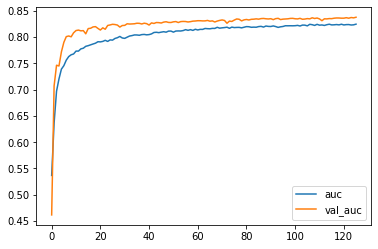

In [90]:
history_df.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df['val_auc'].max()))

Maximum validation binary accuracy: 0.7724356055259705


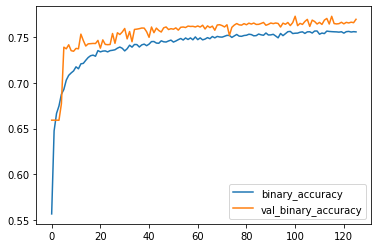

In [91]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df['val_binary_accuracy'].max()))

In [92]:
preds1 = table6_nn.predict(val_X)
preds1

array([[0.65025556],
       [0.08178961],
       [0.084999  ],
       ...,
       [0.47655794],
       [0.0765384 ],
       [0.69562507]], dtype=float32)

In [93]:
preds = (table6_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[11569  2950]
 [ 2168  5475]]


# neural network on top 10 most important features per recursive feature elimination package 

## (big thanks to Jack for getting these for us)

In [94]:
y = full_df.iloc[:,-1]

features = ['qty_slash_url', 'length_url', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'directory_length', 'qty_hyphen_file', 'file_length', 'asn_ip', 'time_domain_activation']
X = full_df[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_slash_url,length_url,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,directory_length,qty_hyphen_file,file_length,asn_ip,time_domain_activation
5676,1,11,0,0,1,1,0,0,262254,155
39002,0,13,0,0,0,0,0,0,2818,0
1732,0,16,0,0,0,0,0,0,15169,5858
39668,0,26,0,0,0,0,0,0,14061,4285
82035,0,28,0,0,0,0,0,0,29671,6669


In [95]:
tf.keras.backend.clear_session()

#neural net

top_10_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[10]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

top_10_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


top_10_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [96]:
history1 = top_10_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 42us/sample - loss: 0.6974 - binary_accuracy: 0.5883 - auc: 0.5580 - val_loss: 0.6472 - val_binary_accuracy: 0.6629 - val_auc: 0.5312
Epoch 2/250
46539/46539 [==============================] - 1s 16us/sample - loss: 0.6105 - binary_accuracy: 0.6664 - auc: 0.6841 - val_loss: 0.6177 - val_binary_accuracy: 0.6593 - val_auc: 0.7534
Epoch 3/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5757 - binary_accuracy: 0.6823 - auc: 0.7258 - val_loss: 0.5825 - val_binary_accuracy: 0.6594 - val_auc: 0.7609
Epoch 4/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5597 - binary_accuracy: 0.6880 - auc: 0.7422 - val_loss: 0.5505 - val_binary_accuracy: 0.6592 - val_auc: 0.7799
Epoch 5/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5516 - binary_accuracy: 0.6939 - auc: 0.7473 - val_loss: 0.5366 - val_binary_accur

In [97]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,0.356018,0.837124,0.894400,0.443868,0.776146,0.879803
std,0.111998,0.078207,0.084505,0.177932,0.115061,0.089839
min,0.253925,0.588281,0.558043,0.215379,0.583776,0.531156
25%,0.274531,0.829906,0.894699,0.239295,0.666349,0.819629
50%,0.302122,0.875073,0.937681,0.500963,0.730372,0.878607
75%,0.387580,0.891403,0.947373,0.582482,0.902888,0.964028
max,0.697419,0.898666,0.955720,0.733240,0.918580,0.970013


In [98]:
train_acc = top_10_nn.evaluate(train_X, train_y)
test_acc = top_10_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 3s 149us/sample - loss: 0.2321 - binary_accuracy: 0.9182 - auc: 0.9634


In [99]:
dict(zip(top_10_nn.metrics_names, test_acc))

{'loss': 0.2321308366056707, 'binary_accuracy': 0.9181933, 'auc': 0.96343756}

Minimum validation loss (binary_crossentropy): 0.2153790087213036


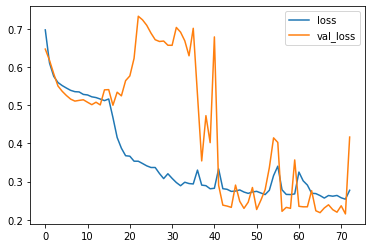

In [100]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9700127840042114


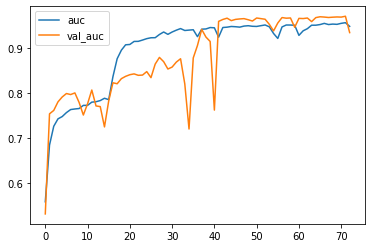

In [101]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.918580174446106


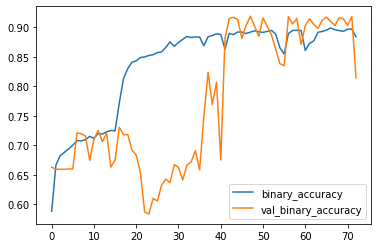

In [102]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [103]:
preds1 = top_10_nn.predict(val_X)
preds1

array([[0.84465563],
       [0.0034959 ],
       [0.5838141 ],
       ...,
       [0.15156552],
       [0.00334087],
       [0.84469306]], dtype=float32)

In [104]:
preds = (top_10_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13467  1052]
 [  761  6882]]


# neural network on top 25 most important features per recursive feature elimination package

In [105]:
y = full_df.iloc[:,-1]

features = ['qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_at_directory', 'qty_comma_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory', 'directory_length',
       'qty_dot_file', 'qty_hyphen_file', 'qty_at_file',
       'qty_exclamation_file', 'qty_space_file', 'qty_dollar_file',
       'file_length', 'time_response', 'asn_ip', 'time_domain_activation',
       'time_domain_expiration', 'ttl_hostname']
X = full_df[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_slash_url,length_url,qty_dot_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_at_directory,qty_comma_directory,...,qty_at_file,qty_exclamation_file,qty_space_file,qty_dollar_file,file_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,ttl_hostname
5676,1,11,1,10,0,0,0,1,0,0,...,0,0,0,0,0,8.696835,262254,155,209,3011
39002,0,13,3,13,0,0,0,0,0,0,...,0,0,0,0,0,0.244978,2818,0,2625,247
1732,0,16,2,16,0,0,0,0,0,0,...,0,0,0,0,0,0.430590,15169,5858,350,14399
39668,0,26,2,26,0,0,0,0,0,0,...,0,0,0,0,0,0.617731,14061,4285,97,7199
82035,0,28,2,28,0,0,0,0,0,0,...,0,0,0,0,0,0.149499,29671,6669,269,21598


In [106]:
tf.keras.backend.clear_session()

#neural net

top_25_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[25]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

top_25_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


top_25_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [107]:
history1 = top_25_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 39us/sample - loss: 0.7157 - binary_accuracy: 0.5753 - auc: 0.5794 - val_loss: 0.6450 - val_binary_accuracy: 0.6592 - val_auc: 0.6330
Epoch 2/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.6065 - binary_accuracy: 0.6632 - auc: 0.6874 - val_loss: 0.6112 - val_binary_accuracy: 0.6592 - val_auc: 0.7384
Epoch 3/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.5755 - binary_accuracy: 0.6861 - auc: 0.7272 - val_loss: 0.5772 - val_binary_accuracy: 0.6592 - val_auc: 0.7723
Epoch 4/250
46539/46539 [==============================] - 1s 18us/sample - loss: 0.5621 - binary_accuracy: 0.6985 - auc: 0.7452 - val_loss: 0.5567 - val_binary_accuracy: 0.6592 - val_auc: 0.7985
Epoch 5/250
46539/46539 [==============================] - 1s 17us/sample - loss: 0.5499 - binary_accuracy: 0.7066 - auc: 0.7570 - val_loss: 0.5322 - val_binary_accur

In [108]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,0.308314,0.861592,0.920679,0.335047,0.844303,0.927391
std,0.112948,0.071427,0.073545,0.175245,0.104842,0.073320
min,0.218688,0.575345,0.579355,0.185997,0.453123,0.633029
25%,0.233473,0.863469,0.925666,0.217025,0.792791,0.914322
50%,0.253701,0.895378,0.956272,0.252948,0.897072,0.966533
75%,0.328651,0.905090,0.962801,0.421634,0.913567,0.972776
max,0.715650,0.911988,0.967094,1.101798,0.929861,0.977859


In [109]:
train_acc = top_25_nn.evaluate(train_X, train_y)
test_acc = top_25_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 3s 152us/sample - loss: 0.1893 - binary_accuracy: 0.9270 - auc: 0.9773


In [110]:
dict(zip(top_25_nn.metrics_names, test_acc))

{'loss': 0.18930804950437513, 'binary_accuracy': 0.9269922, 'auc': 0.9772673}

Minimum validation loss (binary_crossentropy): 0.18599733080803468


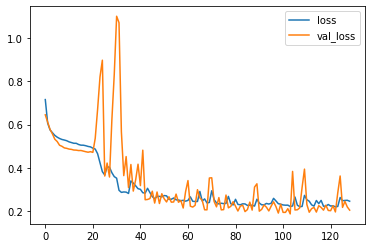

In [111]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9778593182563782


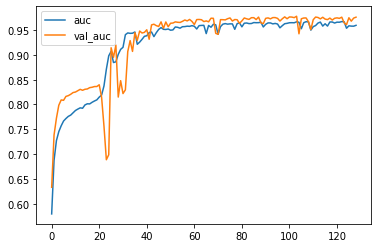

In [112]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9298606514930725


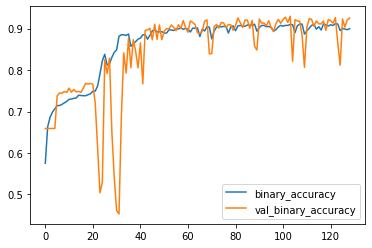

In [113]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [115]:
preds1 = top_25_nn.predict(val_X)
preds1

array([[0.91154224],
       [0.00474623],
       [0.43367967],
       ...,
       [0.04760307],
       [0.00585189],
       [0.90397924]], dtype=float32)

In [116]:
preds = (top_25_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13508  1011]
 [  607  7036]]


# neural network on top 50 most important features per recursive feature elimination package

In [117]:
y = full_df.iloc[:,-1]

features = ['qty_dot_url', 'qty_hyphen_url', 'qty_slash_url', 'length_url',
       'qty_dot_domain', 'qty_vowels_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_at_directory', 'qty_and_directory',
       'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory',
       'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'directory_length', 'qty_dot_file',
       'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file',
       'qty_questionmark_file', 'qty_equal_file', 'qty_at_file',
       'qty_and_file', 'qty_exclamation_file', 'qty_space_file',
       'qty_tilde_file', 'qty_comma_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
       'qty_percent_file', 'file_length', 'params_length', 'time_response',
       'asn_ip', 'time_domain_activation', 'time_domain_expiration',
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects']
X = full_df[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_slash_url,length_url,qty_dot_domain,qty_vowels_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,...,time_response,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects
5676,1,0,1,11,1,2,10,0,0,0,...,8.696835,262254,155,209,1,6,2,3011,1,0
39002,3,0,0,13,3,2,13,0,0,0,...,0.244978,2818,0,2625,4,4,2,247,1,1
1732,2,0,0,16,2,5,16,0,0,0,...,0.430590,15169,5858,350,1,2,1,14399,0,0
39668,2,0,0,26,2,9,26,0,0,0,...,0.617731,14061,4285,97,1,2,4,7199,0,1
82035,2,0,0,28,2,7,28,0,0,0,...,0.149499,29671,6669,269,1,4,4,21598,0,0


In [118]:
tf.keras.backend.clear_session()

#neural net

top_50_nn = keras.Sequential([
                          layers.InputLayer(input_shape=[50]),
                          layers.Dense(units=64, activation='relu'),              # second layer - first dense layer - 64 output neurons w/ rectified linear unit activation
                          layers.BatchNormalization(),                            # third layer - first batch normalization
                          layers.Dropout(0.2),                                    # fourth layer - first dropout layer - drop 20% of neurons
                          layers.Dense(units=64, activation='relu'),              # fifth layer - second dense layer - 64 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # sixth layer - second batch normalization
                          layers.Dropout(0.2),                                    # seventh layer - second dropout layer - drop 20% of neurons 
                          layers.Dense(units=50, activation='relu'),              # eighth layer -  third dense layer - 50 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # ninth layer - third batch normalization
                          layers.Dropout(0.20),                                   # tenth layer - third dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # eleventh layer - fourth dense layer - 32 output neurons w/ ReLU activation 
                          layers.BatchNormalization(),                            # twelfth layer - fourth batch normalization
                          layers.Dropout(0.2),                                    # thirteenth layer - fourth dropout layer - drop 20% of neurons
                          layers.Dense(units=32, activation='relu'),              # fourteenth layer - fifth dense layer - 32 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # fifteenth layer - fifth batch normalization
                          layers.Dropout(0.2),                                    # sixteenth layer - fifth dropout layer - drop 20% of neurons
                          layers.Dense(units=16, activation='relu'),              # seventeenth layer - sixth dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # eighteenth layer - sixth batch normalization
                          layers.Dropout(0.40),                                   # nineteenth layer - sixth dropout layer - drop 40% of neurons
                          layers.Dense(units=16, activation='relu'),              # twentieth layer - seventh dense layer - 16 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-first layer - seventh batch normalization
                          layers.Dropout(0.40),                                   # twenty-second layer - seventh dropout layer - drop 40% of neurons
                          layers.Dense(units=111, activation='relu'),             # twenty-third layer - eighth dense layer - 111 output neurons w/ ReLU activation
                          layers.BatchNormalization(),                            # twenty-fourth layer - eighth batch normalization
                          layers.Flatten(),                                       # twenty-fifth layer - flatten - adds column to X for predictions to fit
                          layers.Dense(units=1, activation='sigmoid')             # twenty-sixth layer - output layer - 1 output neuron w/ sigmoid activation (preds <> 0, 1)
])

top_50_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


top_50_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3

In [119]:
history1 = top_50_nn.fit(train_X, train_y, validation_split=0.30, batch_size= 1500, epochs=250, callbacks = [earlystopping])

Train on 46539 samples, validate on 19946 samples
Epoch 1/250
46539/46539 [==============================] - 2s 46us/sample - loss: 0.7105 - binary_accuracy: 0.5808 - auc: 0.5499 - val_loss: 0.6494 - val_binary_accuracy: 0.6592 - val_auc: 0.5341
Epoch 2/250
46539/46539 [==============================] - 1s 20us/sample - loss: 0.6254 - binary_accuracy: 0.6598 - auc: 0.6493 - val_loss: 0.6281 - val_binary_accuracy: 0.6592 - val_auc: 0.7053
Epoch 3/250
46539/46539 [==============================] - 1s 21us/sample - loss: 0.5869 - binary_accuracy: 0.6908 - auc: 0.7144 - val_loss: 0.5929 - val_binary_accuracy: 0.6592 - val_auc: 0.7700
Epoch 4/250
46539/46539 [==============================] - 1s 20us/sample - loss: 0.5655 - binary_accuracy: 0.6979 - auc: 0.7401 - val_loss: 0.5603 - val_binary_accuracy: 0.6592 - val_auc: 0.7863
Epoch 5/250
46539/46539 [==============================] - 1s 19us/sample - loss: 0.5493 - binary_accuracy: 0.7071 - auc: 0.7567 - val_loss: 0.5385 - val_binary_accur

In [120]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.341880,0.845718,0.902717,0.342061,0.839449,0.922125
std,0.115589,0.075429,0.083953,0.121904,0.080635,0.076983
min,0.233239,0.580782,0.549851,0.199999,0.659180,0.534064
25%,0.261174,0.836889,0.901572,0.238055,0.770856,0.910631
50%,0.285225,0.883700,0.944493,0.292396,0.875539,0.955409
75%,0.376243,0.895684,0.953392,0.450400,0.904906,0.968785
max,0.710512,0.908872,0.962054,0.649413,0.927554,0.974056


In [121]:
train_acc = top_50_nn.evaluate(train_X, train_y)
test_acc = top_50_nn.evaluate(val_X, val_y)

22162/22162 [==============================] - 3s 142us/sample - loss: 0.2026 - binary_accuracy: 0.9245 - auc: 0.9737


In [122]:
dict(zip(top_50_nn.metrics_names, test_acc))

{'loss': 0.20261655343860702, 'binary_accuracy': 0.9245104, 'auc': 0.9737453}

Minimum validation loss (binary_crossentropy): 0.19999872435063235


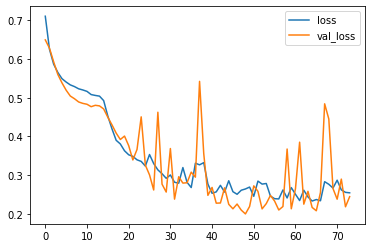

In [123]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9740564227104187


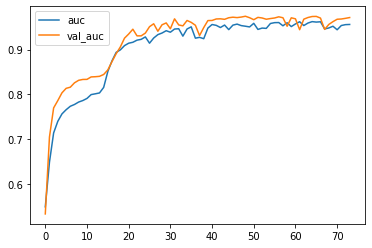

In [124]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9275543689727783


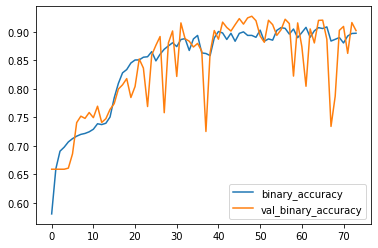

In [125]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [127]:
preds1 = top_50_nn.predict(val_X)
preds1

array([[0.90059376],
       [0.00330812],
       [0.46118492],
       ...,
       [0.10345289],
       [0.00416066],
       [0.8978245 ]], dtype=float32)

In [128]:
preds = (top_50_nn.predict(val_X) > 0.5).astype('int32')
cm1 = confusion_matrix(val_y, preds)
print(cm1)

[[13545   974]
 [  699  6944]]
